# Federated Learning 


## 1. Imports et configuration


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
import seaborn as sns

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device utilisé: {device}")


Device utilisé: cpu


## 2. Chargement de MNIST


In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # Normalisation standard pour MNIST
])

# Charger le dataset MNIST
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)

print(f"Taille du dataset d'entraînement: {len(train_dataset)}")
print(f"Taille du dataset de test: {len(test_dataset)}")


Taille du dataset d'entraînement: 60000
Taille du dataset de test: 10000


## 3. Définition du CNN


In [7]:
class SimpleCNN(nn.Module):
    """CNN simple avec 2 couches convolutives et 2 couches denses pour MNIST"""
    
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.25)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model_test = SimpleCNN().to(device)
x_test = torch.randn(1, 1, 28, 28).to(device)
output_test = model_test(x_test)


## 4. Entraînement simple


Époque 1/10 - Loss: 1.6251, Accuracy: 49.60%
Époque 2/10 - Loss: 0.6371, Accuracy: 79.40%
Époque 3/10 - Loss: 0.3917, Accuracy: 87.20%
Époque 4/10 - Loss: 0.2269, Accuracy: 93.30%
Époque 5/10 - Loss: 0.1894, Accuracy: 94.00%
Époque 6/10 - Loss: 0.1418, Accuracy: 95.30%
Époque 7/10 - Loss: 0.1026, Accuracy: 97.30%
Époque 8/10 - Loss: 0.0792, Accuracy: 97.50%
Époque 9/10 - Loss: 0.0643, Accuracy: 97.90%
Époque 10/10 - Loss: 0.0585, Accuracy: 98.40%


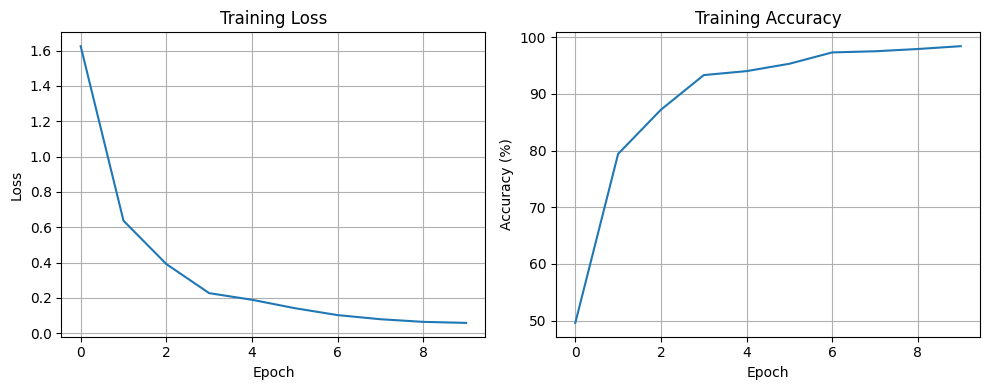

In [8]:
# Créer un sous-ensemble pour tester rapidement
subset_indices = torch.randperm(len(train_dataset))[:1000]
subset_dataset = Subset(train_dataset, subset_indices)
train_loader = DataLoader(subset_dataset, batch_size=64, shuffle=True)

# Créer le modèle et l'optimiseur
model = SimpleCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Entraînement 
num_epochs = 10
model.train()
epoch_losses = []
epoch_accuracies = []

for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        pred = output.argmax(dim=1)
        correct += pred.eq(target).sum().item()
        total += target.size(0)
    
    accuracy = 100. * correct / total
    avg_loss = running_loss / len(train_loader)
    epoch_losses.append(avg_loss)
    epoch_accuracies.append(accuracy)
    print(f"Époque {epoch+1}/{num_epochs} - Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epoch_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epoch_accuracies)
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy')
plt.grid(True)
plt.tight_layout()
plt.show()


## 5. Fonction de moyennage des paramètres


In [9]:
def average_model_parameters(models, average_weight):
    if isinstance(average_weight, (list, tuple)):
        average_weight = {i: w for i, w in enumerate(average_weight)}
    
    total_weight = sum(average_weight.values())
    if abs(total_weight - 1.0) > 1e-6:
        print(f"Attention: les poids ne sont pas normalisés (somme={total_weight}), normalisation automatique...")
        average_weight = {k: v/total_weight for k, v in average_weight.items()}
    
    averaged_model = deepcopy(models[0])
    
    for param in averaged_model.parameters():
        param.data.zero_()
    
    for idx, model in enumerate(models):
        if idx not in average_weight:
            continue
        weight = average_weight[idx]
        for avg_param, model_param in zip(averaged_model.parameters(), model.parameters()):
            avg_param.data += weight * model_param.data
    
    return averaged_model


## 6. Implémentation de l'Algorithme 1 (FedAvg)


In [39]:
def compute_class_weights(dataset, num_classes=7):
    """
    Compute class weights for imbalanced dataset.
    Uses inverse frequency weighting: weight = total_samples / (num_classes * class_count)
    
    Args:
        dataset: PyTorch dataset
        num_classes: Number of classes
    
    Returns:
        Tensor of class weights normalized to device
    """
    from collections import Counter
    
    # Count occurrences of each class
    class_counts = Counter()
    for i in range(len(dataset)):
        _, label = dataset[i]
        class_counts[label] += 1
    
    total_samples = len(dataset)
    
    # Calculate weights: inverse frequency
    weights = []
    for class_idx in range(num_classes):
        count = class_counts.get(class_idx, 1)  # Avoid division by zero
        # Weight inversely proportional to frequency
        weight = total_samples / (num_classes * count)
        weights.append(weight)
    
    # Normalize weights (optional, but helps with stability)
    weights = torch.FloatTensor(weights)
    weights = weights / weights.sum() * num_classes  # Normalize so average is 1
    
    return weights.to(device)


def train_local_model(model, train_loader, epochs, batch_size, lr=0.001, class_weights=None):
    """
    Train a local model on client data.
    
    Args:
        model: Model to train
        train_loader: DataLoader for training data
        epochs: Number of training epochs
        batch_size: Batch size (for logging)
        lr: Learning rate
        class_weights: Optional tensor of class weights for imbalanced datasets
    """
    model.train()
    optimizer = optim.SGD(model.parameters(), lr=lr)
    
    # Use class weights if provided, otherwise standard CrossEntropyLoss
    if class_weights is not None:
        criterion = nn.CrossEntropyLoss(weight=class_weights)
    else:
        criterion = nn.CrossEntropyLoss()
    
    for _ in range(epochs):
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
    
    return model


def federated_averaging(global_model, client_datasets, client_weights, 
                        num_rounds, C=1.0, E=1, B=50, lr=0.001, test_dataset=None, class_weights=None):
    """
    Federated Averaging Algorithm (FedAvg)
    
    Args:
        global_model: Initial global model
        client_datasets: List of client datasets
        client_weights: Dictionary mapping client index to weight
        num_rounds: Number of federated rounds
        C: Fraction of clients to select per round
        E: Number of local epochs
        B: Batch size
        lr: Learning rate
        test_dataset: Optional test dataset for evaluation during training
        class_weights: Optional tensor of class weights for imbalanced datasets
    """
    num_clients = len(client_datasets)
    
    # Create DataLoaders for each client
    client_loaders = []
    for dataset in client_datasets:
        loader = DataLoader(dataset, batch_size=B, shuffle=True)
        client_loaders.append(loader)
    
    # Initialize global model
    current_global_model = deepcopy(global_model).to(device)
    round_accuracies = []
    
    # Setup test loader if test_dataset is provided
    if test_dataset is not None:
        test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
    else:
        test_loader = None
        # Use global test_dataset with warning (for backward compatibility with MNIST)
        try:
            test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
            print("Warning: Using global test_dataset. Consider passing test_dataset parameter.")
        except:
            pass
    
    for round_num in range(num_rounds):
        # Select clients (fraction C)
        m = max(int(C * num_clients), 1)  # At least 1 client
        selected_clients = np.random.choice(num_clients, size=m, replace=False)
        
        # List to store trained local models
        local_models = []
        local_weights = {}
        
        # Train each selected client
        for model_idx, client_idx in enumerate(selected_clients):
            local_model = deepcopy(current_global_model)
            
            local_model = train_local_model(
                local_model, 
                client_loaders[client_idx], 
                epochs=E, 
                batch_size=B, 
                lr=lr,
                class_weights=class_weights
            )
            
            local_models.append(local_model)
            if client_idx in client_weights:
                local_weights[model_idx] = client_weights[client_idx]
            else:
                local_weights[model_idx] = 1.0 / len(selected_clients)
        
        # Normalize weights
        total_weight = sum(local_weights.values())
        local_weights = {k: v/total_weight for k, v in local_weights.items()}
        
        # Aggregation
        current_global_model = average_model_parameters(local_models, local_weights)
        current_global_model = current_global_model.to(device)
        
        # Evaluate on test set if provided
        if test_loader is not None:
            current_global_model.eval()
            correct = 0
            total = 0
            with torch.no_grad():
                for data, target in test_loader:
                    data, target = data.to(device), target.to(device)
                    output = current_global_model(data)
                    pred = output.argmax(dim=1)
                    correct += pred.eq(target).sum().item()
                    total += target.size(0)
            acc = 100.0 * correct / total
            round_accuracies.append(acc)
        
        print(f"Round {round_num+1}/{num_rounds} completed")
    
    return current_global_model, round_accuracies



In [11]:
num_samples_per_client = 600
total_samples = num_samples_per_client * 2

all_indices = torch.randperm(len(train_dataset))[:total_samples]

client1_indices = all_indices[:num_samples_per_client]
client2_indices = all_indices[num_samples_per_client:]

client1_dataset = Subset(train_dataset, client1_indices)
client2_dataset = Subset(train_dataset, client2_indices)

print(f"Client 1: {len(client1_dataset)} exemples")
print(f"Client 2: {len(client2_dataset)} exemples")

client_weights = {
    0: 0.5,
    1: 0.5
}

client_datasets = [client1_dataset, client2_dataset]

global_model = SimpleCNN().to(device)
print("\n✓ Datasets et modèles préparés!")


Client 1: 600 exemples
Client 2: 600 exemples

✓ Datasets et modèles préparés!


Round 1/10 terminé
Round 2/10 terminé
Round 3/10 terminé
Round 4/10 terminé
Round 5/10 terminé
Round 6/10 terminé
Round 7/10 terminé
Round 8/10 terminé
Round 9/10 terminé
Round 10/10 terminé


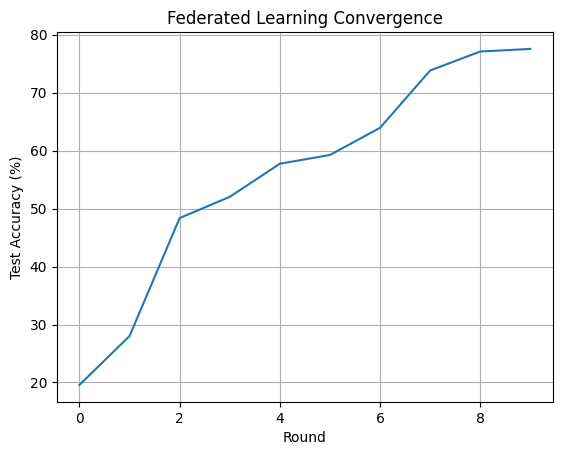

In [12]:
trained_model, fed_accuracies = federated_averaging(
    global_model=global_model,
    client_datasets=client_datasets,
    client_weights=client_weights,
    num_rounds=10,
    C=1.0,
    E=1,
    B=50,
    lr=0.01
)

plt.plot(fed_accuracies)
plt.xlabel('Round')
plt.ylabel('Test Accuracy (%)')
plt.title('Federated Learning Convergence')
plt.grid(True)
plt.show()


## 8. Visualisation des résultats



Résultats sur le dataset de test:
  - Loss moyenne: 0.9515
  - Accuracy: 77.55%
  - Nombre d'exemples testés: 10000

  Client 1: Loss=0.9310, Accuracy=77.00%
  Client 2: Loss=0.9158, Accuracy=79.33%


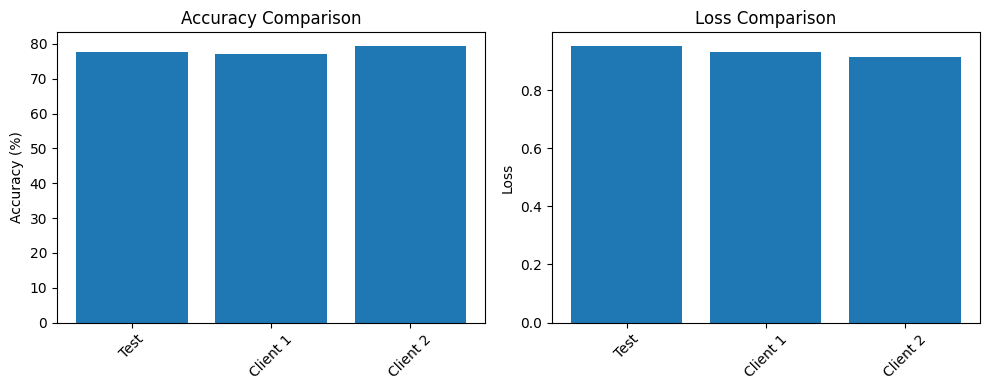

In [13]:
trained_model.eval()
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

correct = 0
total = 0
all_losses = []
criterion = nn.CrossEntropyLoss()

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = trained_model(data)
        loss = criterion(output, target)
        all_losses.append(loss.item())
        pred = output.argmax(dim=1)
        correct += pred.eq(target).sum().item()
        total += target.size(0)

test_accuracy = 100. * correct / total
avg_test_loss = np.mean(all_losses)

print(f"\nRésultats sur le dataset de test:")
print(f"  - Loss moyenne: {avg_test_loss:.4f}")
print(f"  - Accuracy: {test_accuracy:.2f}%")
print(f"  - Nombre d'exemples testés: {total}\n")

client_accuracies = []
client_losses = []

for client_idx, client_dataset in enumerate(client_datasets):
    client_loader = DataLoader(client_dataset, batch_size=64, shuffle=False)
    correct = 0
    total = 0
    total_loss = 0

    with torch.no_grad():
        for data, target in client_loader:
            data, target = data.to(device), target.to(device)
            output = trained_model(data)
            loss = criterion(output, target)
            total_loss += loss.item()
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
            total += target.size(0)

    accuracy = 100.0 * correct / total
    avg_loss = total_loss / len(client_loader)
    client_accuracies.append(accuracy)
    client_losses.append(avg_loss)
    print(f"  Client {client_idx + 1}: Loss={avg_loss:.4f}, Accuracy={accuracy:.2f}%")

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.bar(['Test'] + [f'Client {i+1}' for i in range(len(client_accuracies))], 
        [test_accuracy] + client_accuracies)
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Comparison')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
plt.bar(['Test'] + [f'Client {i+1}' for i in range(len(client_losses))], 
        [avg_test_loss] + client_losses)
plt.ylabel('Loss')
plt.title('Loss Comparison')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Avant ca marchait pas parce que :
chaque client part d'un point différent, 
les gradients peuvent pointer dans des directions très différentes, 
la moyenne peut se trouver dans une région moins optimale

## 9. Étude impact nombre de données


In [44]:
# Enhanced evaluation function with per-class metrics
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support

def evaluate_model_enhanced(model, test_loader, class_names=None):
    """
    Enhanced evaluation function with per-class metrics.
    
    Args:
        model: Trained model
        test_loader: DataLoader for test data
        class_names: List of class names (optional)
    
    Returns:
        Dictionary with metrics and predictions
    """
    model.eval()
    criterion = nn.CrossEntropyLoss()
    
    all_preds = []
    all_labels = []
    total_loss = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            total_loss += loss.item()
            
            pred = output.argmax(dim=1)
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(target.cpu().numpy())
    
    # Calculate metrics
    accuracy = 100.0 * sum(p == l for p, l in zip(all_preds, all_labels)) / len(all_labels)
    avg_loss = total_loss / len(test_loader)
    
    # Per-class metrics
    precision, recall, f1, support = precision_recall_fscore_support(
        all_labels, all_preds, average=None, zero_division=0
    )
    
    # Per-class accuracy
    num_classes = len(np.unique(all_labels))
    per_class_accuracy = []
    for class_idx in range(num_classes):
        class_mask = np.array(all_labels) == class_idx
        if class_mask.sum() > 0:
            class_correct = sum((np.array(all_preds) == class_idx) & class_mask)
            class_acc = 100.0 * class_correct / class_mask.sum()
        else:
            class_acc = 0.0
        per_class_accuracy.append(class_acc)
    
    results = {
        'accuracy': accuracy,
        'loss': avg_loss,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'support': support,
        'per_class_accuracy': per_class_accuracy,
        'predictions': all_preds,
        'labels': all_labels
    }
    
    # Print classification report
    if class_names is not None:
        print("\n" + "="*70)
        print("ENHANCED EVALUATION RESULTS")
        print("="*70)
        print(f"\nOverall Accuracy: {accuracy:.2f}%")
        print(f"Overall Loss: {avg_loss:.4f}")
        print("\nPer-Class Metrics:")
        print("-"*70)
        print(f"{'Class':<10} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Accuracy':<12} {'Support':<10}")
        print("-"*70)
        for i, name in enumerate(class_names):
            print(f"{name:<10} {precision[i]:<12.4f} {recall[i]:<12.4f} {f1[i]:<12.4f} "
                  f"{per_class_accuracy[i]:<12.2f} {int(support[i]):<10}")
        print("="*70)
        
        # Classification report
        print("\nClassification Report:")
        print(classification_report(all_labels, all_preds, target_names=class_names, zero_division=0))
    
    return results


In [14]:
import pandas as pd

def evaluate_model(model, test_loader):
    model.eval()
    criterion = nn.CrossEntropyLoss()
    correct = 0
    total = 0
    total_loss = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            total_loss += loss.item()
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
            total += target.size(0)
    
    accuracy = 100.0 * correct / total
    avg_loss = total_loss / len(test_loader)
    return accuracy, avg_loss


In [37]:
def run_experiment(num_clients, samples_per_client, train_dataset, test_dataset, model_class, 
                  num_rounds=10, use_class_weights=False, num_classes=10, E=1, B=50, lr=0.01):
    """
    Run a federated learning experiment.
    
    Args:
        num_clients: Number of clients
        samples_per_client: Number of samples per client
        train_dataset: Training dataset
        test_dataset: Test dataset
        model_class: Model class to instantiate
        num_rounds: Number of federated rounds
        use_class_weights: Whether to use class weights for imbalanced datasets
        num_classes: Number of classes (7 for HAM10000, 10 for MNIST)
        E: Number of local epochs
        B: Batch size
        lr: Learning rate
    """
    total_samples = num_clients * samples_per_client
    all_indices = torch.randperm(len(train_dataset))[:total_samples]
    
    client_datasets = []
    client_weights = {}
    
    for i in range(num_clients):
        start_idx = i * samples_per_client
        end_idx = (i + 1) * samples_per_client
        client_indices = all_indices[start_idx:end_idx]
        client_datasets.append(Subset(train_dataset, client_indices))
        client_weights[i] = 1.0 / num_clients
    
    # Calculate class weights if requested (based on full train dataset)
    class_weights = None
    if use_class_weights:
        class_weights = compute_class_weights(train_dataset, num_classes=num_classes)
        print(f"Class weights computed: {class_weights.cpu().numpy()}")
    
    global_model = model_class().to(device)
    
    trained_model, _ = federated_averaging(
        global_model=global_model,
        client_datasets=client_datasets,
        client_weights=client_weights,
        num_rounds=num_rounds,
        C=1.0,
        E=E,
        B=B,
        lr=lr,
        test_dataset=test_dataset,
        class_weights=class_weights
    )
    
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
    accuracy, loss = evaluate_model(trained_model, test_loader)
    
    return accuracy, loss


In [16]:
num_clients_list = [2, 3, 5]
samples_list = [25, 50, 100, 200, 500]

results = []

for num_clients in num_clients_list:
    for samples_per_client in samples_list:
        print(f"\nClients: {num_clients}, Samples: {samples_per_client}")
        accuracy, loss = run_experiment(num_clients, samples_per_client, train_dataset, test_dataset, SimpleCNN)
        results.append({
            'Clients': num_clients,
            'Samples': samples_per_client,
            'Accuracy': accuracy,
            'Loss': loss
        })
        print(f"Accuracy: {accuracy:.2f}%, Loss: {loss:.4f}")



Clients: 2, Samples: 25
Round 1/10 terminé
Round 2/10 terminé
Round 3/10 terminé
Round 4/10 terminé
Round 5/10 terminé
Round 6/10 terminé
Round 7/10 terminé
Round 8/10 terminé
Round 9/10 terminé
Round 10/10 terminé
Accuracy: 17.30%, Loss: 2.2724

Clients: 2, Samples: 50
Round 1/10 terminé
Round 2/10 terminé
Round 3/10 terminé
Round 4/10 terminé
Round 5/10 terminé
Round 6/10 terminé
Round 7/10 terminé
Round 8/10 terminé
Round 9/10 terminé
Round 10/10 terminé
Accuracy: 26.11%, Loss: 2.2604

Clients: 2, Samples: 100
Round 1/10 terminé
Round 2/10 terminé
Round 3/10 terminé
Round 4/10 terminé
Round 5/10 terminé
Round 6/10 terminé
Round 7/10 terminé
Round 8/10 terminé
Round 9/10 terminé
Round 10/10 terminé
Accuracy: 19.46%, Loss: 2.2106

Clients: 2, Samples: 200
Round 1/10 terminé
Round 2/10 terminé
Round 3/10 terminé
Round 4/10 terminé
Round 5/10 terminé
Round 6/10 terminé
Round 7/10 terminé
Round 8/10 terminé
Round 9/10 terminé
Round 10/10 terminé
Accuracy: 59.54%, Loss: 2.0533

Clients: 


Tableau des résultats (Accuracy %):
Clients      2      3      5
Samples                     
25       17.30  23.26  18.05
50       26.11  16.96  14.57
100      19.46  21.87  26.84
200      59.54  57.92  57.53
500      69.72  77.64  80.93


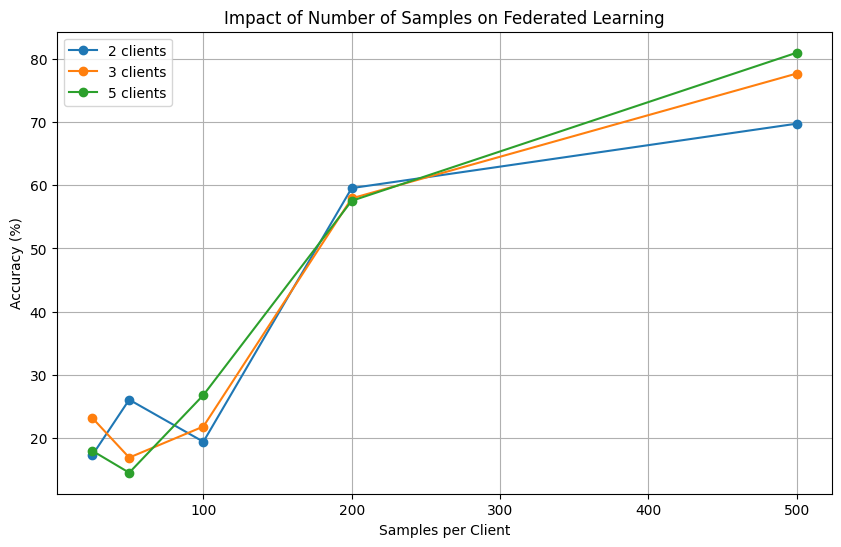

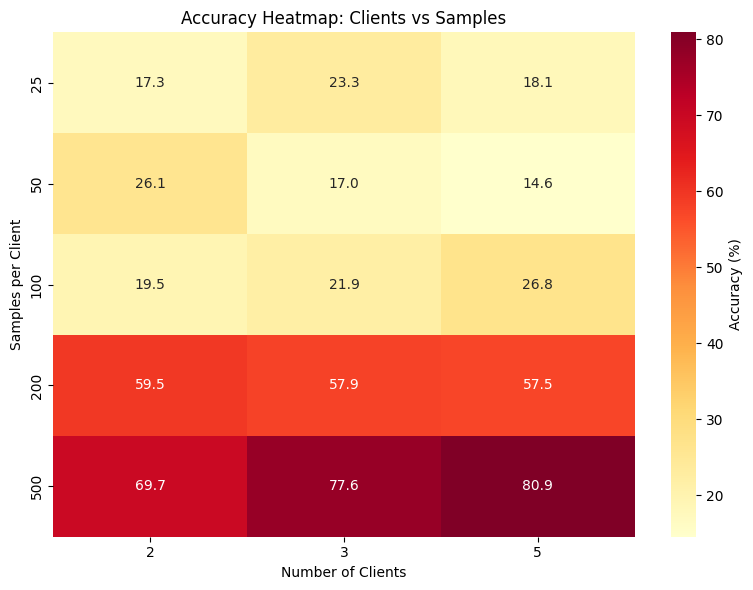

In [17]:
df = pd.DataFrame(results)
pivot_table = df.pivot(index='Samples', columns='Clients', values='Accuracy')
print("\nTableau des résultats (Accuracy %):")
print(pivot_table.round(2))

plt.figure(figsize=(10, 6))
for num_clients in num_clients_list:
    client_data = df[df['Clients'] == num_clients]
    plt.plot(client_data['Samples'], client_data['Accuracy'], marker='o', label=f'{num_clients} clients')

plt.xlabel('Samples per Client')
plt.ylabel('Accuracy (%)')
plt.title('Impact of Number of Samples on Federated Learning')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(pivot_table, annot=True, fmt='.1f', cmap='YlOrRd', cbar_kws={'label': 'Accuracy (%)'})
plt.title('Accuracy Heatmap: Clients vs Samples')
plt.ylabel('Samples per Client')
plt.xlabel('Number of Clients')
plt.tight_layout()
plt.show()


## 10. Chargement HAM10000


In [ ]:
from PIL import Image
import os
from torch.utils.data import Dataset

class_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
num_classes = 7

class HAM10000Dataset(Dataset):
    def __init__(self, csv_file, img_dirs, transform=None):
        import pandas as pd
        self.df = pd.read_csv(csv_file)
        if isinstance(img_dirs, str):
            self.img_dirs = [img_dirs]
        else:
            self.img_dirs = img_dirs
        self.transform = transform
        self.class_to_idx = {
            'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3,
            'mel': 4, 'nv': 5, 'vasc': 6
        }
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_name = self.df.iloc[idx]['image_id'] + '.jpg'
        img_path = None
        for img_dir in self.img_dirs:
            potential_path = os.path.join(img_dir, img_name)
            if os.path.exists(potential_path):
                img_path = potential_path
                break
        
        if img_path is None:
            raise FileNotFoundError(f"Image {img_name} not found in any of the directories: {self.img_dirs}")
        
        image = Image.open(img_path).convert('RGB')
        label = self.class_to_idx[self.df.iloc[idx]['dx']]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

def load_ham10000(data_dir='data/', train_split=0.8):
    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    csv_file = os.path.join(data_dir, 'HAM10000_metadata.csv')
    img_dir_1 = os.path.join(data_dir, 'ham10000_images_part_1')
    img_dir_2 = os.path.join(data_dir, 'ham10000_images_part_2')
    img_dirs = []
    
    if os.path.exists(img_dir_1):
        img_dirs.append(img_dir_1)
    if os.path.exists(img_dir_2):
        img_dirs.append(img_dir_2)
    
    if not img_dirs:
        raise FileNotFoundError(f"No image directories found in {data_dir}")
    
    full_dataset = HAM10000Dataset(csv_file, img_dirs, transform=transform)
    train_size = int(train_split * len(full_dataset))
    test_size = len(full_dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(
        full_dataset, [train_size, test_size]
    )
    
    return train_dataset, test_dataset

class SimpleCNN_HAM(nn.Module):
    def __init__(self):
        super(SimpleCNN_HAM, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, 7)
        self.dropout = nn.Dropout(0.25)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 16 * 16)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


✓ Dataset, modèle et classes définis pour HAM10000


In [ ]:
ham_train, ham_test = load_ham10000()
print(f"Train: {len(ham_train)}, Test: {len(ham_test)}")


Train: 8012 exemples
Test: 2003 exemples
✓ Dataset HAM10000 chargé avec succès


HAM10000 - ANALYSE DE DISTRIBUTION DES CLASSES

1. DISTRIBUTION TRAIN SET:
----------------------------------------------------------------------
  akiec :   255 ( 3.18%) | Attendu:   3.3% | Diff:  0.12%
  bcc   :   407 ( 5.08%) | Attendu:   5.1% | Diff:  0.02%
  bkl   :   890 (11.11%) | Attendu:  11.0% | Diff:  0.11%
  df    :    81 ( 1.01%) | Attendu:   1.1% | Diff:  0.09%
  mel   :   892 (11.13%) | Attendu:  11.1% | Diff:  0.03%
  nv    :  5368 (67.00%) | Attendu:  67.0% | Diff:  0.00%
  vasc  :   119 ( 1.49%) | Attendu:   1.4% | Diff:  0.09%

2. DISTRIBUTION TEST SET:
----------------------------------------------------------------------
  akiec :    72 ( 3.59%) | Attendu:   3.3% | Diff:  0.29%
  bcc   :   107 ( 5.34%) | Attendu:   5.1% | Diff:  0.24%
  bkl   :   209 (10.43%) | Attendu:  11.0% | Diff:  0.57%
  df    :    34 ( 1.70%) | Attendu:   1.1% | Diff:  0.60%
  mel   :   221 (11.03%) | Attendu:  11.1% | Diff:  0.07%
  nv    :  1337 (66.75%) | Attendu:  67.0% | Diff:  0.25%
  

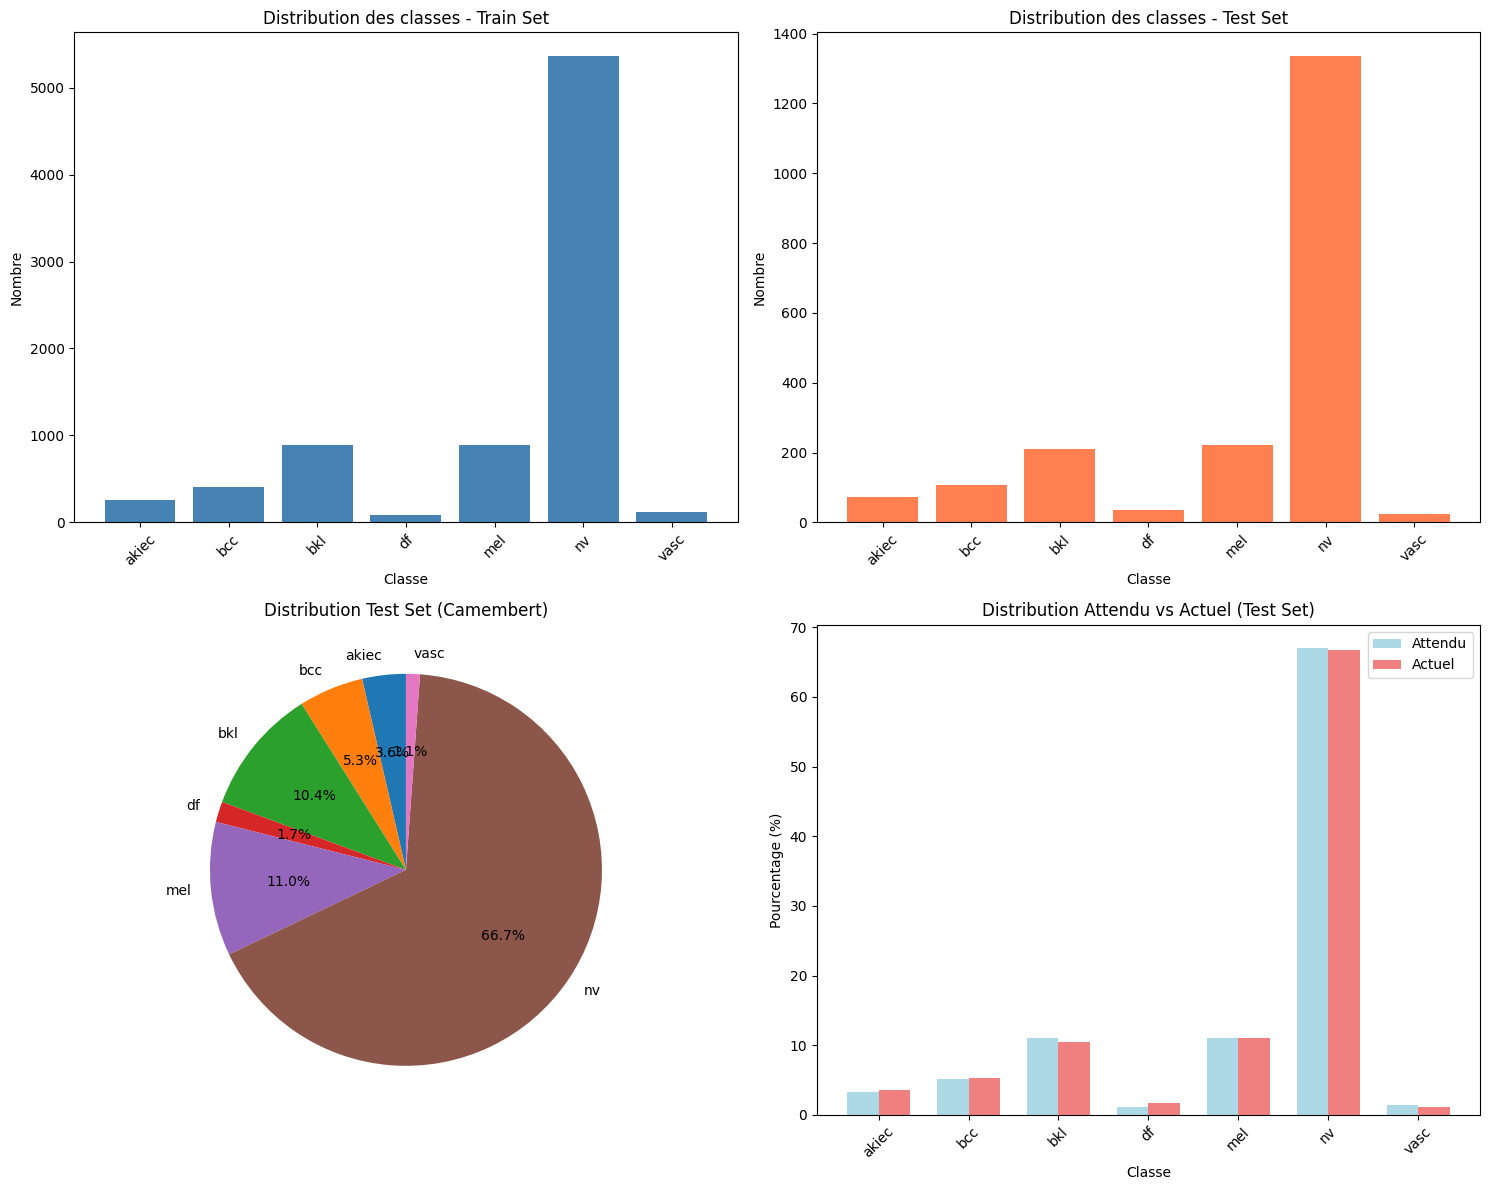


4. CONCLUSION:
----------------------------------------------------------------------
  L'imbilançage des classes est NORMAL pour le dataset HAM10000.
  La classe 'nv' représente ~67% des échantillons, ce qui correspond à la distribution attendue.
  Cet imbalançage nécessite l'utilisation de class weights ou d'autres techniques de rééquilibrage.


In [ ]:
from collections import Counter

train_labels = [ham_train[i][1] for i in range(len(ham_train))]
test_labels = [ham_test[i][1] for i in range(len(ham_test))]

train_counts = Counter(train_labels)
test_counts = Counter(test_labels)

majority_class_idx = max(test_counts.items(), key=lambda x: x[1])[0]
majority_percentage = 100.0 * test_counts[majority_class_idx] / len(test_labels)

print(f"Class distribution - Train: {dict(train_counts)}")
print(f"Class distribution - Test: {dict(test_counts)}")
print(f"Majority class: {class_names[majority_class_idx]} ({majority_percentage:.1f}%)")

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.bar(class_names, [train_counts.get(i, 0) for i in range(7)])
plt.title('Train Set Distribution')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
plt.bar(class_names, [test_counts.get(i, 0) for i in range(7)])
plt.title('Test Set Distribution')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
ham_results = []

for num_clients in num_clients_list:
    for samples_per_client in samples_list:
        print(f"Clients: {num_clients}, Samples: {samples_per_client}")
        accuracy, loss = run_experiment(
            num_clients=num_clients,
            samples_per_client=samples_per_client,
            train_dataset=ham_train,
            test_dataset=ham_test,
            model_class=SimpleCNN_HAM,
            num_rounds=10,
            use_class_weights=True,
            num_classes=7,
            E=3,
            B=32,
            lr=0.001
        )
        ham_results.append({
            'Clients': num_clients,
            'Samples': samples_per_client,
            'Accuracy': accuracy,
            'Loss': loss
        })
        print(f"Accuracy: {accuracy:.2f}%, Loss: {loss:.4f}")


EXPÉRIENCES FEDERATED LEARNING HAM10000
Paramètres: Class Weights, lr=0.001, E=3, B=32, num_classes=7

Clients: 2, Samples: 25
Class weights computed: [0.9286977  0.5818622  0.26608756 2.9236782  0.26549098 0.04411661
 1.9900666 ]
Round 1/10 completed
Round 2/10 completed
Round 3/10 completed
Round 4/10 completed
Round 5/10 completed
Round 6/10 completed
Round 7/10 completed
Round 8/10 completed
Round 9/10 completed
Round 10/10 completed
Accuracy: 1.15%, Loss: 2.0972

Clients: 2, Samples: 50
Class weights computed: [0.9286977  0.5818622  0.26608756 2.9236782  0.26549098 0.04411661
 1.9900666 ]
Round 1/10 completed
Round 2/10 completed
Round 3/10 completed
Round 4/10 completed
Round 5/10 completed
Round 6/10 completed
Round 7/10 completed
Round 8/10 completed
Round 9/10 completed
Round 10/10 completed
Accuracy: 2.30%, Loss: 1.8751

Clients: 2, Samples: 100
Class weights computed: [0.9286977  0.5818622  0.26608756 2.9236782  0.26549098 0.04411661
 1.9900666 ]
Round 1/10 completed
Round 2

RÉSUMÉ DES RÉSULTATS HAM10000

Tableau Accuracy (%):
Clients      2      3      5
Samples                     
25        1.15   5.34  12.93
50        2.30   1.15   1.25
100      66.25  64.00  55.12
200      17.47   2.20  12.03
500      40.79  52.72  46.73

Tableau Loss:
Clients       2       3       5
Samples                        
25       2.0972  1.8877  1.8708
50       1.8751  1.9508  1.9703
100      1.5769  1.6725  1.7289
200      1.7850  1.8959  1.8807
500      1.7983  1.6923  1.7501

Meilleure Configuration:
  Clients: 2, Samples: 100, Accuracy: 66.25%, Loss: 1.5769


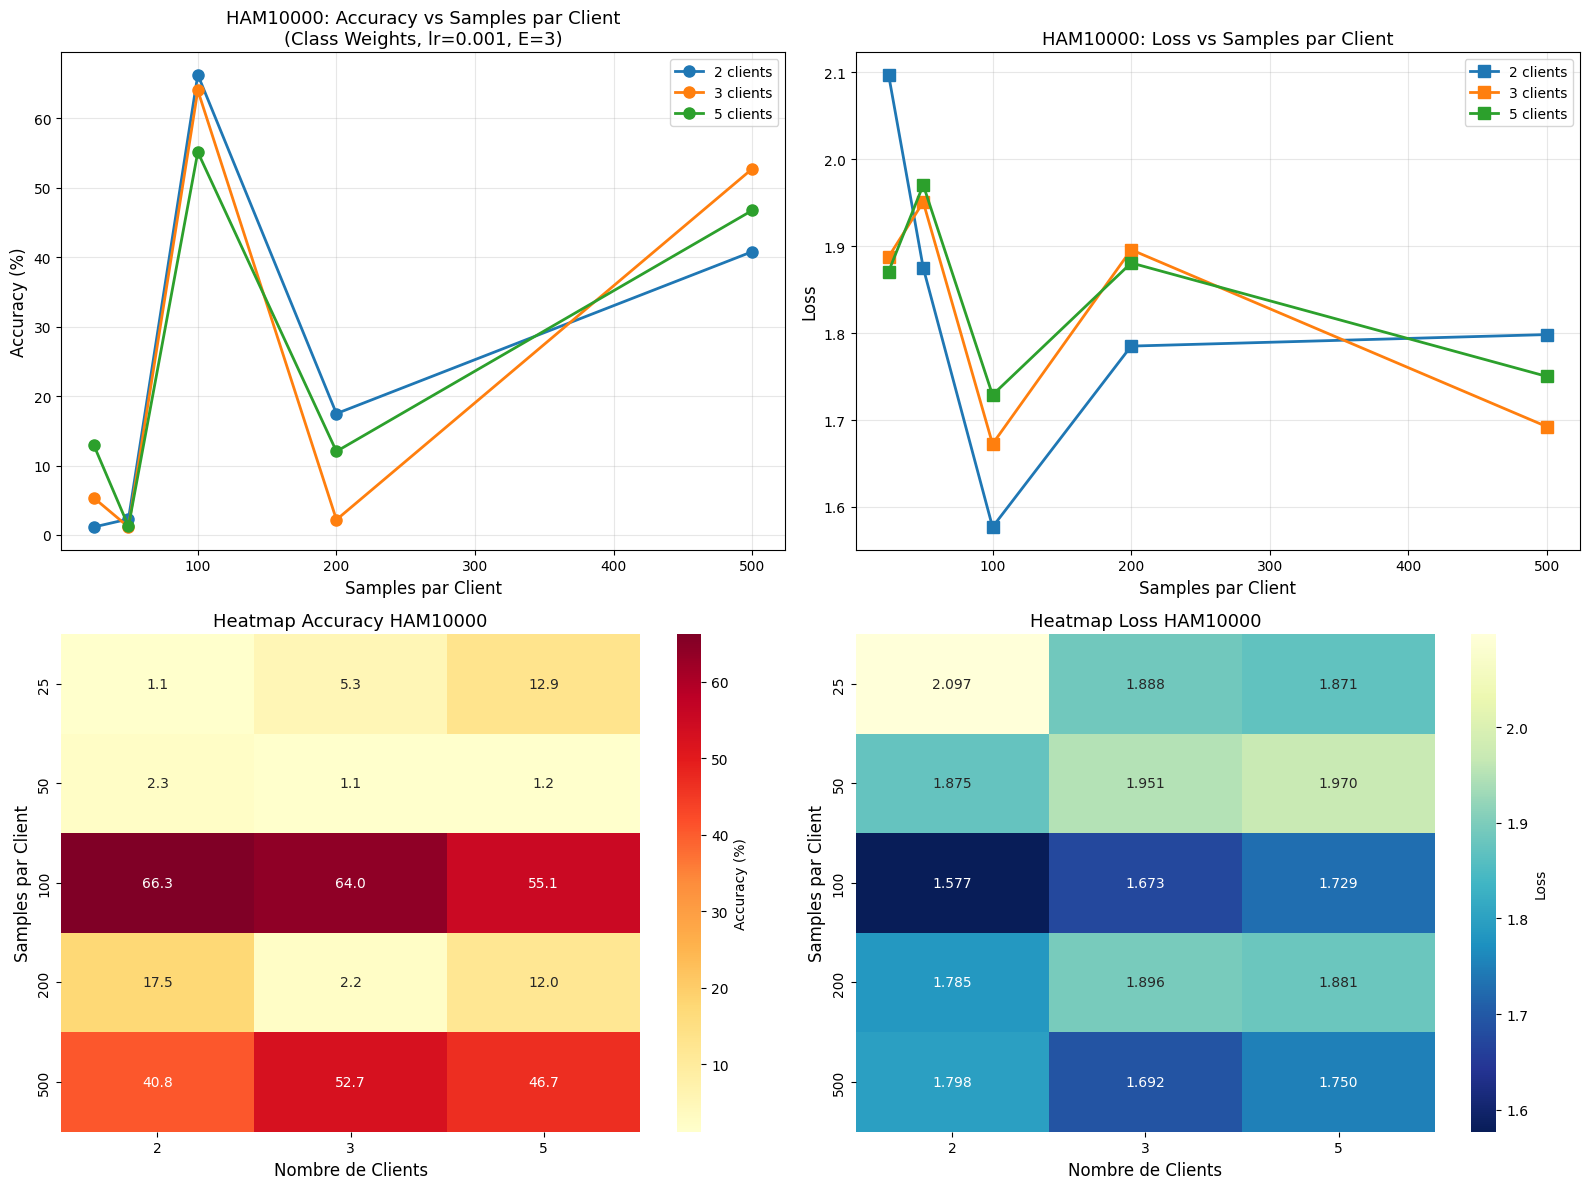


ANALYSE:
Avec class weights et hyperparamètres ajustés:
- Le modèle devrait apprendre toutes les classes, pas seulement la classe majoritaire 'nv'
- L'accuracy devrait varier avec le nombre de samples et de clients
- Learning rate plus faible (0.001) et plus d'époques (E=3) aident avec les données déséquilibrées


In [ ]:
import pandas as pd

df_ham = pd.DataFrame(ham_results)
pivot_ham = df_ham.pivot(index='Samples', columns='Clients', values='Accuracy')

print("Accuracy Table (%):")
print(pivot_ham.round(2))

best_idx = df_ham['Accuracy'].idxmax()
best_config = df_ham.loc[best_idx]
print(f"\nBest: {int(best_config['Clients'])} clients, {int(best_config['Samples'])} samples, "
      f"Accuracy: {best_config['Accuracy']:.2f}%")

plt.figure(figsize=(10, 6))
for num_clients in num_clients_list:
    client_data = df_ham[df_ham['Clients'] == num_clients]
    plt.plot(client_data['Samples'], client_data['Accuracy'], marker='o', label=f'{num_clients} clients')
plt.xlabel('Samples per Client')
plt.ylabel('Accuracy (%)')
plt.title('HAM10000: Accuracy vs Samples')
plt.legend()
plt.grid(True)
plt.show()


VÉRIFICATION: Le modèle apprend-il toutes les classes?

Class weights: [0.9286977  0.5818622  0.26608756 2.9236782  0.26549098 0.04411661
 1.9900666 ]
Round 1/5 completed
Round 2/5 completed
Round 3/5 completed
Round 4/5 completed
Round 5/5 completed

ENHANCED EVALUATION RESULTS

Overall Accuracy: 48.78%
Overall Loss: 1.8623

Per-Class Metrics:
----------------------------------------------------------------------
Class      Precision    Recall       F1-Score     Accuracy     Support   
----------------------------------------------------------------------
akiec      0.0000       0.0000       0.0000       0.00         72        
bcc        0.1672       0.4486       0.2437       44.86        107       
bkl        0.2641       0.2919       0.2773       29.19        209       
df         0.0000       0.0000       0.0000       0.00         34        
mel        0.3846       0.0679       0.1154       6.79         221       
nv         0.8368       0.6328       0.7206       63.28        1337

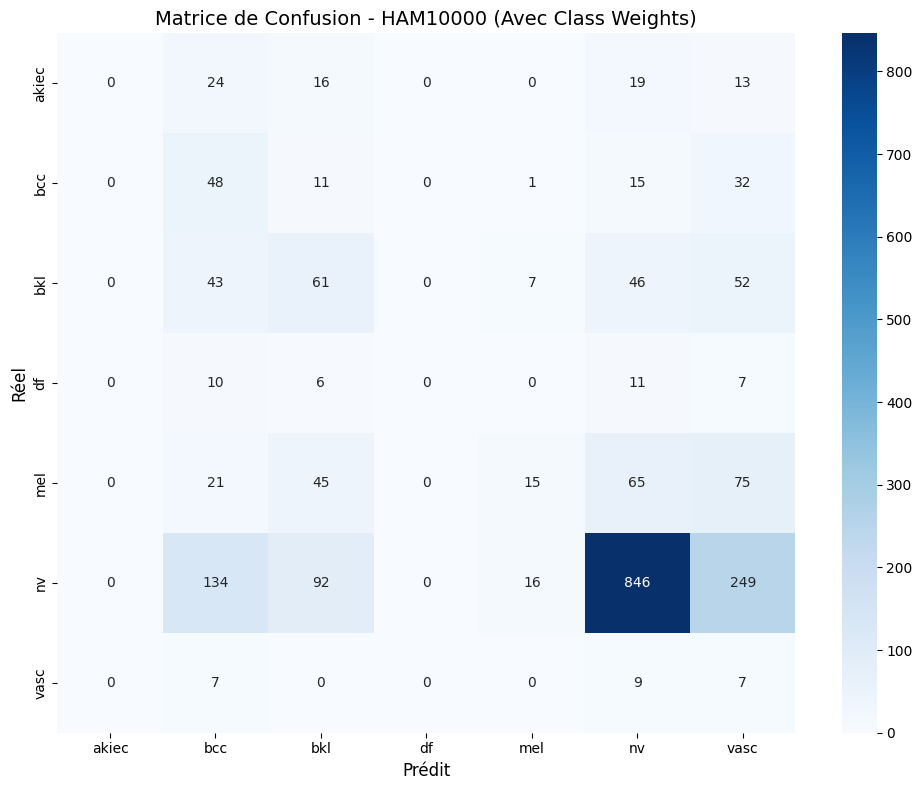


DISTRIBUTION DES PRÉDICTIONS:
  akiec: 0 (0.00%)
  bcc: 287 (14.33%)
  bkl: 231 (11.53%)
  df: 0 (0.00%)
  mel: 39 (1.95%)
  nv: 1011 (50.47%)
  vasc: 435 (21.72%)

RÉSULTAT DE LA VÉRIFICATION:
SUCCÈS: Le modèle prédit plusieurs classes!
Les class weights et hyperparamètres ajustés fonctionnent.


In [ ]:
from sklearn.metrics import confusion_matrix
from collections import Counter

test_model = SimpleCNN_HAM().to(device)
test_client_datasets = [Subset(ham_train, torch.randperm(len(ham_train))[:200]) for _ in range(2)]
test_client_weights = {0: 0.5, 1: 0.5}
test_class_weights = compute_class_weights(ham_train, num_classes=7)

trained_test_model, _ = federated_averaging(
    global_model=test_model,
    client_datasets=test_client_datasets,
    client_weights=test_client_weights,
    num_rounds=5,
    C=1.0,
    E=3,
    B=32,
    lr=0.001,
    test_dataset=ham_test,
    class_weights=test_class_weights
)

test_loader = DataLoader(ham_test, batch_size=64, shuffle=False)
results = evaluate_model_enhanced(trained_test_model, test_loader, class_names=class_names)

cm = confusion_matrix(results['labels'], results['predictions'])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - HAM10000')
plt.tight_layout()
plt.show()

pred_counts = Counter(results['predictions'])
print("Prediction distribution:")
for i, name in enumerate(class_names):
    count = pred_counts.get(i, 0)
    percentage = 100.0 * count / len(results['predictions'])
    print(f"  {name}: {percentage:.1f}%")
